<a href="https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks/Nearest_Neighbors_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax 
import jax.numpy as jnp 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def sample_mean(key, c, d, cluster=True):
  subkey1, subkey2 = jax.random.split(key, 2)
  means = jnp.where(cluster, jax.random.multivariate_normal(key, mean=jnp.zeros((d,)), cov=jnp.eye(d), shape=(c,)),jnp.zeros(shape=(c, d)))
  return means 

def sample_from_gaussian(key, mean, cov, n) -> jnp.ndarray:
  samples = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(n,))
  return samples

def cluster_sample(key_num, c, n, d, cluster=True):
  key = jax.random.PRNGKey(key_num)
  subkey1, subkey2 = jax.random.split(key)
  subkeys = jax.random.split(subkey2, c) # I shouldn't need to do this, I should be able to complete this in the line above!
  means = sample_mean(subkey1, c, d, cluster)
  cov = jnp.diag(jnp.linspace(0.1,1.,d))
  #cov = jnp.eye(d)  
  data = jax.vmap(sample_from_gaussian, in_axes=(0, 0, None, None))(subkeys, means, cov, n)
  training_data = data[:-1].reshape(-1, d)
  test_obs = data[-1][0]
  return training_data.T, test_obs

In [3]:
def distance(x1, x2):
  return jnp.linalg.norm(x1-x2)

def NN(key_num, c, n, d, k, cluster): 
  data, _ = cluster_sample(key_num, c, n, d, cluster)
  results = -1.*jax.vmap(distance, in_axes=(None, 1))(data[:,0], data[:,1:])
  _, idx = jax.lax.top_k(results, k)
  return jnp.mean(jax.vmap(lambda x: jnp.where(x>(n-1), 1., 0.))(idx))

def avgNN(n_samples, c, n, d, k, cluster=True):
  ans = jax.vmap(NN, in_axes=(0, None, None, None, None, None))(jnp.arange(n_samples), c, n, d, k, cluster)
  return jnp.mean(ans)

In [4]:
c, n, k, s = 25, 25, 5, 5000
results_cluster = [avgNN(s, c, n, i, k, True) for i in range(2,40,2)]
results_iid = [avgNN(s, c, n, i, k, False) for i in range(2,40,2)]

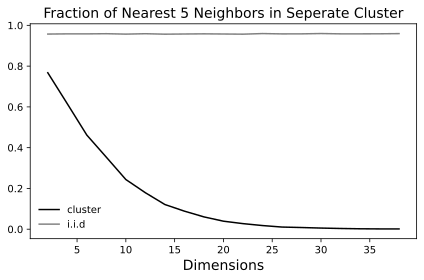

In [5]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(list(range(2, 40, 2)), results_cluster, label='cluster', color='black')
plt.plot(list(range(2, 40, 2)), results_iid, label='i.i.d', color='grey')
plt.title(f'Fraction of Nearest {k} Neighbors in Seperate Cluster', size=14)
plt.xlabel('Dimensions', size=14)
plt.legend(frameon=False)
fig.savefig('nearest_neighbors_increasing_correlation.pdf', format='pdf')
fig.savefig('nearest_neighbors_increasing_correlation.png', format='png')
plt.show()

In [6]:
jnp.diag(jnp.linspace(0.1,1.,3))

DeviceArray([[0.1 , 0.  , 0.  ],
             [0.  , 0.55, 0.  ],
             [0.  , 0.  , 1.  ]], dtype=float32)